# **X-ray and MWL spectral analysis using GammapyXray**

This notebook explains how to perform a simple X-ray and MWL (X-ray + Gamma-ray) spectral analysis using the `GammapyXray` module, based on `Gammapy 0.20.1`. It is structured as follows:

- **Part 1:** Spectral analysis of X-ray data using a simple analytical model (absorbed power law)
- **Part 2:** Spectral analysis of X-ray data using the radiative models from `Naima`
- **Part 3:** Spectral analysis of MWL data using the radiative models from `Naima`

The XMM-Newton data that we analyze in this example are the same that were used in the publication [Gotthelf et al. 2011](https://ui.adsabs.harvard.edu/abs/2011ApJ...729L..16G/abstract). **The purpose of this tutorial is to demonstrate the use of the `GammapyXray` code. The aim is not to provide an accurate physical model of the data, and  the resulting parameters are not discussed.** 

In [1]:
import gammapy
gammapy.__version__

'0.20.1'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import naima
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

In [4]:
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, NaimaSpectralModel, Models
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.maps import MapAxis
from gammapy.catalog import SourceCatalogHGPS

In [5]:
from gammapyXray import *

In [6]:
from sherpa.astro.xspec import XSwabs
from sherpa.models import PowLaw1D

----------------------------------------------------------------------

# Part 1

In this part we perform a simple fit of X-ray spectral data. We jointly fit 3 data sets (one for each of the instruments onboard of the XMM-Newton satellite) using an absorbed power law function. 

### Load and inspect the X-ray data

In [7]:
filename = "XMM_test_files/PN_PWN.grp"
pn_dataset = StandardOGIPDataset.read(filename)
filename = "XMM_test_files/MOS1_PWN.grp"
mos1_dataset = StandardOGIPDataset.read(filename)
filename = "XMM_test_files/MOS2_PWN.grp"
mos2_dataset = StandardOGIPDataset.read(filename)

/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(1.0, 10.0)

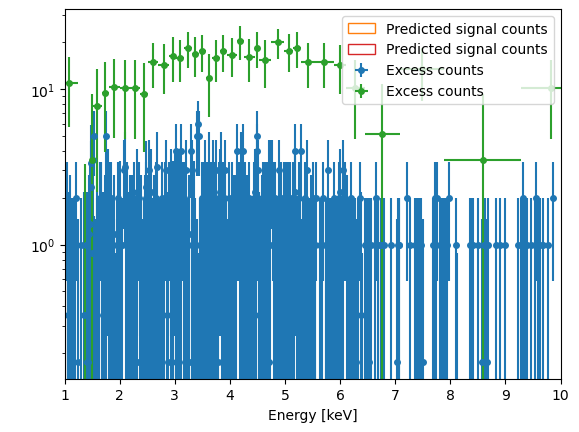

In [8]:
ax = pn_dataset.plot_excess()
ax = pn_dataset.grouped.plot_excess()
plt.xlim(1,10)

(1.0, 10.0)

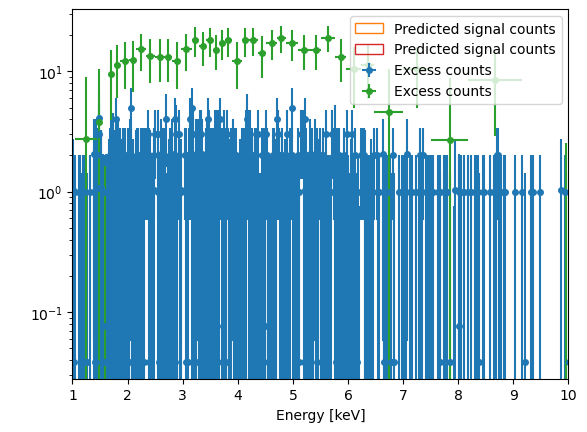

In [9]:
ax = mos1_dataset.plot_excess()
ax = mos1_dataset.grouped.plot_excess()
plt.xlim(1,10)

(1.0, 10.0)

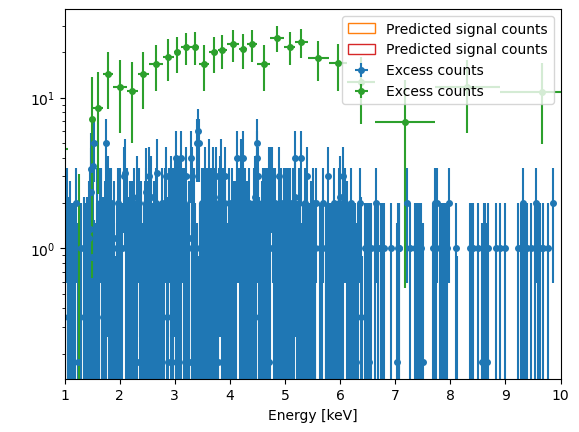

In [10]:
ax = mos2_dataset.plot_excess()
ax = mos2_dataset.grouped.plot_excess()
plt.xlim(1,10)

### Create a joint `Datasets`

In [11]:
xmm_datasets = Datasets(datasets=[pn_dataset, mos1_dataset, mos2_dataset])

The true energy axis of the XMM data starts from 0:

In [12]:
pn_dataset.grouped.geoms["geom_exposure"].axes["energy_true"].edges

<Quantity [0.00000000e+00, 4.99999989e-03, 9.99999978e-03, ...,
           1.19899998e+01, 1.19949999e+01, 1.20000000e+01] keV>

This is incompatible with the current `Gammapy` architecture. As a quick workaround, we can resample the true energy axis by eliminating the first bin. 

In [13]:
for dataset in xmm_datasets:
    dataset.set_min_true_energy(0 * u.keV)

In order to speed up the models evaluation during the fit, we can actually define a even threshold for the true energy axis, say e.g. 0.5 keV:

In [14]:
for dataset in xmm_datasets:
    dataset.set_min_true_energy(0.5 * u.keV)

The latter step is not crucial when fitting analytical models (e.g. absorbed power laws), but it makes a huge difference in terms of computation time for more elaborate models (like the `Naima` ones, see the Part 2 of this tutorial).

### Define a spectral model

In this section we make use of the `~gammapyXray.models.SherpaSpectralModel`, a class that allows to fit the  `XSpec` models (shipped with the `Sherpa` package) within the `Gammapy` framework.

Let's create an absorbed power law function (using e.g. `wabs` absorption) as follows:

In [15]:
pl_sherpa = PowLaw1D()
pl_sherpa.ampl = 1e-3
pl_sherpa.gamma = 2

absorption_sherpa = XSwabs()
absorption_sherpa.nH = 5

pl_gammapy = SherpaSpectralModel(pl_sherpa) 
absorption_gammapy = SherpaSpectralModel(absorption_sherpa, default_units=(u.keV, 1))
spectral_model = pl_gammapy * absorption_gammapy

As a sanity check, we can verify that the `SherpaSpectralModel` we defined is consistent with the plain `Sherpa` and `XSpec` models:


**************************************************************
The wabs model is obsolete and is only included for comparison
with historical results. The tbabs model should be used for
the ISM or phabs for general photoelectric absorption.
**************************************************************


/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


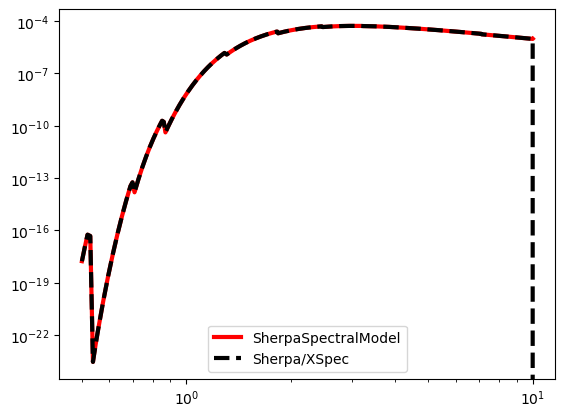

In [16]:
fig, ax = plt.subplots()
energy_grid = np.linspace(0.5, 10.0, 1000) * u.keV

# Gammapy wrapper
ax.loglog(energy_grid, spectral_model(energy_grid), color="r", lw=3, label="SherpaSpectralModel")

#Plain sherpa
spectral_model_sherpa = pl_sherpa * absorption_sherpa
ax.loglog(energy_grid.value, spectral_model_sherpa(energy_grid.value), color="k", ls="--", lw=3, label="Sherpa/XSpec")

plt.legend()

Assign the `SherpaSpectralModel` to the joint data set:

In [17]:
names = [
        xmm_datasets[0].grouped.name, 
        xmm_datasets[1].grouped.name,
        xmm_datasets[2].grouped.name, 
]
model = SkyModel(spectral_model=spectral_model, name="absorbed_powerlaw", datasets_names=names)
xmm_datasets.models=[model]

/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


### Fit

Define min/max values for the free model parameters and inspect the parameters table:

In [18]:
xmm_datasets.models[0].spectral_model.model1.ampl.min = 0
xmm_datasets.models[0].spectral_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str5,float64,str1,int64,float64,float64,bool,bool,str1
spectral,gamma,2.0000e+00,,0.000e+00,nan,nan,False,False,
spectral,ref,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,ampl,1.0000e-03,,0.000e+00,0.000e+00,nan,False,True,
spectral,nH,5.0000e+00,,0.000e+00,nan,nan,False,False,


Restrict the fit range for each instrument:

In [19]:
pn_dataset.mask_fit = pn_dataset._geom.energy_mask(1.5*u.keV, 8*u.keV)
mos1_dataset.mask_fit = mos1_dataset._geom.energy_mask(1.5*u.keV, 8*u.keV)
mos2_dataset.mask_fit = mos2_dataset._geom.energy_mask(1.5*u.keV, 8*u.keV)

Run the binned joint-likelihood fit:

In [20]:
%%time
fit = Fit()
fit_result = fit.run(xmm_datasets)

/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


CPU times: user 4.22 s, sys: 0 ns, total: 4.22 s
Wall time: 4.21 s


/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


Inspect the fit output:

In [21]:
print(fit_result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 129
	total stat : 68.00

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [22]:
fit_result.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str5,float64,str1,float64,float64,float64,bool,bool,str1
spectral,gamma,1.8847e+00,,2.712e-01,nan,nan,False,False,
spectral,ref,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,ampl,5.9912e-04,,2.785e-04,0.000e+00,nan,False,True,
spectral,nH,6.2033e+00,,1.021e+00,nan,nan,False,False,


(1.5, 8.0)

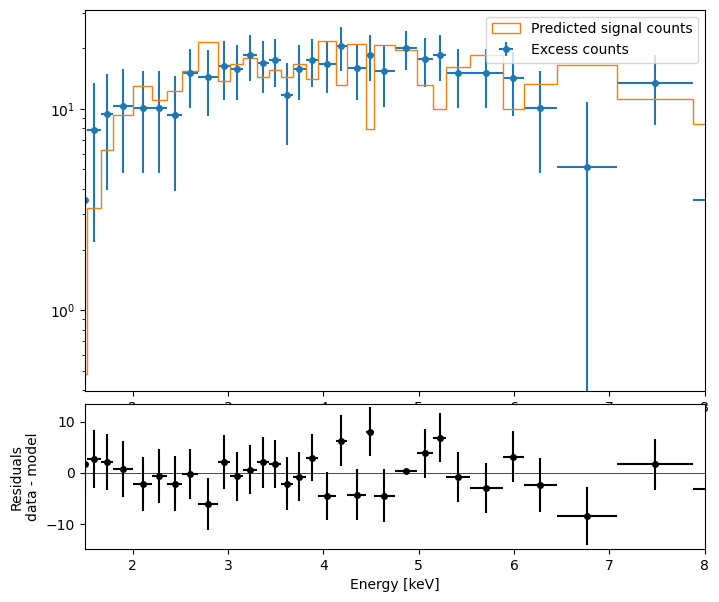

In [23]:
ax_spectrum, ax_residuals = pn_dataset.plot_fit()
ax_spectrum.set_xlim(1.5, 8)
ax_residuals.set_xlim(1.5, 8)

(1.5, 8.0)

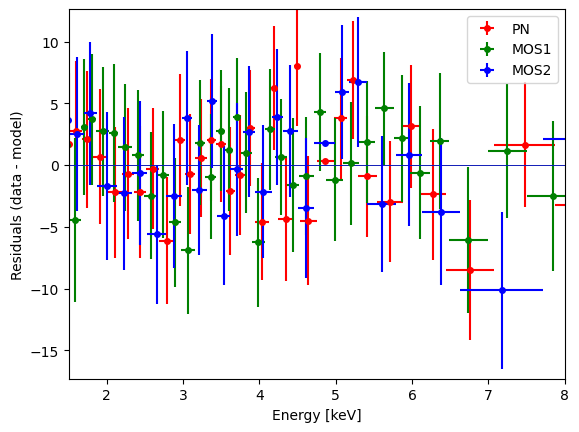

In [24]:
pn_dataset.plot_residuals_spectral(color="r", label="PN")
mos1_dataset.plot_residuals_spectral(color="g", label="MOS1")
mos2_dataset.plot_residuals_spectral(color="b", label="MOS2")
plt.legend()
plt.xlim(1.5, 8)

-----------------------------------------

# Part 2

In this part we substitute the simple model used in the Part 1 with a synchrotron radiative model from `Naima`. The big advantage of using `GammapyXray` is that it allows to easily combine the `XSpec` absorption models with physically-motivated `Naima` models with a simple multiplication.

### Define a synchrotron model

Let's define the synchrotron model, assuming an exponential-cutoff power law distribution for the parent electron population and a standard magnetic field value of 3 $\mu$G:

In [25]:
# The electron distribution
particle_distribution = naima.models.ExponentialCutoffPowerLaw(
    amplitude=4e+32 / u.eV,
    e_0=1.0 * u.TeV,
    alpha=2.2,
    e_cutoff=180*u.TeV, 
    beta=1,               
)  

# The synchrotron radiative model
Eemin=0.1 * u.TeV
Eemax=500 * u.PeV
nEed = 40
radiative_model_SYN = naima.radiative.Synchrotron(
    particle_distribution,
    B=3 * u.uG,
    Eemin=Eemin,
    Eemax=Eemax,
    nEed=nEed
)

Note that we have set the [nEed parameter](https://github.com/zblz/naima/blob/4e7b85dfcbc00d5e4474c2f339ace0e565c9ffcd/src/naima/radiative.py#L275), defining the number of points per decade in energy for the electron distribution, to 40. This speeds up significantly the model evaluation, compared to the default `nEed=100` value, at the expense of a negligible precision loss.

The `Naima` radiative model can be passed as an argument to the `~gammapy.models.NaimaSpectralModel`, and then multiplied by the `XSpec` absorption model defined in Part 1:

In [26]:
synchrotron = NaimaSpectralModel(radiative_model_SYN, distance=1 * u.kpc)
synchrotron_absorbed = absorption_gammapy * synchrotron

/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)
/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)
/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


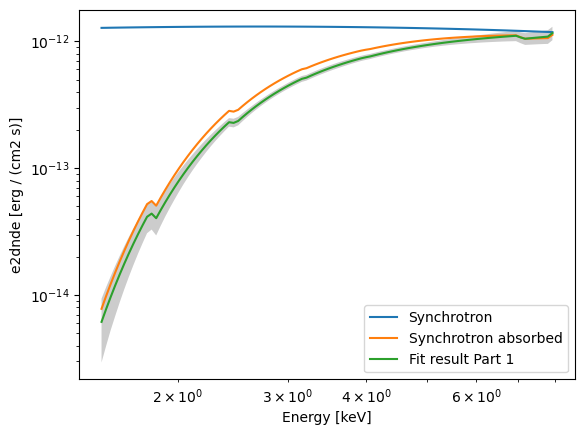

In [27]:
opts = {
    "sed_type": "e2dnde",
    "energy_bounds": [1.5 * u.keV, 8 * u.keV]
}

synchrotron.plot(label="Synchrotron", **opts)
synchrotron_absorbed.plot(label="Synchrotron absorbed", **opts)

spectral_model.plot(label="Fit result Part 1", **opts)
spectral_model.plot_error(**opts)

plt.legend()

As shown in this plot, the first-guess parameters of the electron distribution have been manually fine tuned to provide a decent fit of the data, using the fit result obtained in Part 1 as a reference.

### Fit

We freeze some parameters and define min/max ranges:

In [28]:
synchrotron.beta.frozen = True
synchrotron.e_0.frozen = True

# The absorption column density has been estimated with good accuracy in Part 1, so we freeze it here
synchrotron_absorbed.model1.nH.frozen = True

# We also freeze the magnetic field and cutoff energy, that however could be fitted if needed 
synchrotron.B.frozen = True
synchrotron.e_cutoff.frozen = True

####### min/max #######
synchrotron.amplitude.min = synchrotron.amplitude.value / 1e3
synchrotron.amplitude.max = synchrotron.amplitude.value * 1e3
synchrotron.alpha.min = 1
synchrotron.alpha.max = 4

Assign the synchrotron model to the XMM `Datasets`:

In [29]:
model_naima_syn = SkyModel(spectral_model=synchrotron_absorbed, name="synchrotron_absorbed", datasets_names=names)
xmm_datasets.models = [model_naima_syn]

/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


In [30]:
xmm_datasets.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str20,str8,str9,float64,str4,float64,float64,float64,bool,bool,str1
synchrotron_absorbed,spectral,nH,6.2033e+00,,1.021e+00,nan,nan,True,False,
synchrotron_absorbed,spectral,amplitude,4.0000e+32,eV-1,0.000e+00,4.000e+29,4.000e+35,False,True,
synchrotron_absorbed,spectral,e_0,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
synchrotron_absorbed,spectral,alpha,2.2000e+00,,0.000e+00,1.000e+00,4.000e+00,False,False,
synchrotron_absorbed,spectral,e_cutoff,1.8000e+02,TeV,0.000e+00,nan,nan,True,False,
synchrotron_absorbed,spectral,beta,1.0000e+00,,0.000e+00,nan,nan,True,False,
synchrotron_absorbed,spectral,B,3.0000e+00,uG,0.000e+00,nan,nan,True,False,


In [31]:
xmm_datasets.models.parameters.free_parameters.unique_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str4,int64,float64,float64,bool,bool,str1
spectral,amplitude,4.0000e+32,eV-1,0.000e+00,4.000e+29,4.000e+35,False,True,
spectral,alpha,2.2000e+00,,0.000e+00,1.000e+00,4.000e+00,False,False,


In [32]:
%%time
fit = Fit()
fit_result = fit.run(xmm_datasets)

/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)
/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


CPU times: user 2min 2s, sys: 10.2 s, total: 2min 12s
Wall time: 2min 12s


Inspect the fit output:

In [33]:
print(fit_result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 223
	total stat : 67.50

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [34]:
fit_result.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str4,float64,float64,float64,bool,bool,str1
spectral,nH,6.2033e+00,,0.000e+00,nan,nan,True,False,
spectral,amplitude,3.3274e+31,eV-1,5.097e+31,4.000e+29,4.000e+35,False,True,
spectral,e_0,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,alpha,1.7342e+00,,2.999e-01,1.000e+00,4.000e+00,False,False,
spectral,e_cutoff,1.8000e+02,TeV,0.000e+00,nan,nan,True,False,
spectral,beta,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,B,3.0000e+00,uG,0.000e+00,nan,nan,True,False,


(1.5, 8.0)

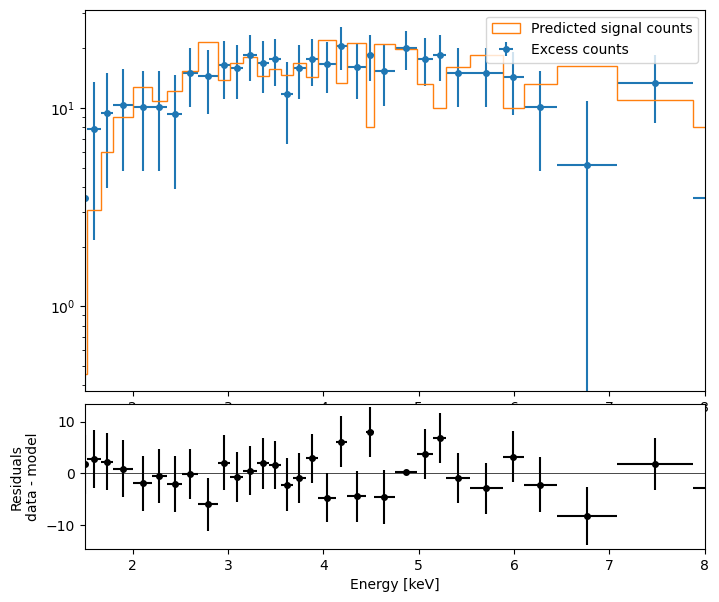

In [35]:
ax_spectrum, ax_residuals = pn_dataset.plot_fit()
ax_spectrum.set_xlim(1.5, 8)
ax_residuals.set_xlim(1.5, 8)

### Fit

(1.5, 8.0)

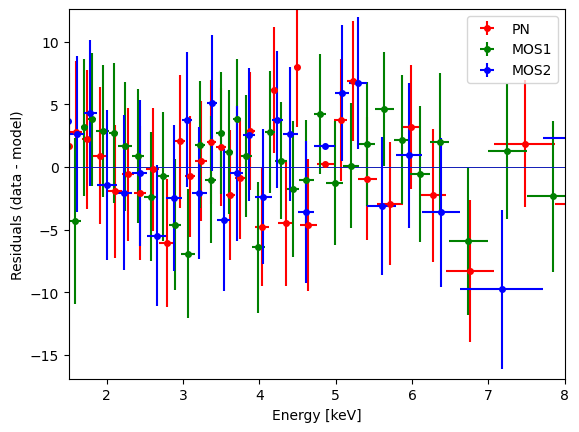

In [36]:
pn_dataset.plot_residuals_spectral(color="r", label="PN")
mos1_dataset.plot_residuals_spectral(color="g", label="MOS1")
mos2_dataset.plot_residuals_spectral(color="b", label="MOS2")
plt.legend()
plt.xlim(1.5, 8)

Compare the fit result with Part 1:

/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


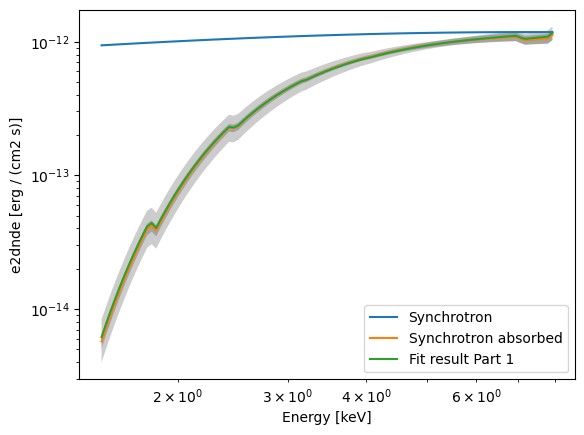

In [37]:
opts = {
    "sed_type": "e2dnde",
    "energy_bounds": [1.5 * u.keV, 8 * u.keV]
}

synchrotron.plot(label="Synchrotron", **opts)

synchrotron_absorbed.plot(label="Synchrotron absorbed", **opts)
synchrotron_absorbed.plot_error(**opts)

spectral_model.plot(label="Fit result Part 1", **opts)
spectral_model.plot_error(**opts)

plt.legend()

-----------------------------------------

# Part 3

In this part we perform a MWL fit, by simultaneously modeling the XMM-Newton data and the SED of the corresponding H.E.S.S. source ([HESS J1849-000](http://tevcat.uchicago.edu/?mode=1;id=188)). Note that any other kind of Gamma-ray data, such as spectral On-Off or 3D data sets, could be also used.

### Create a H.E.S.S. `FluxPointsDataset`

You first need to download the HGPS catalog, manually or by un-commenting the following cell:

In [38]:
#%%bash
#curl -O https://www.mpi-hd.mpg.de/hfm/HESS/hgps/data/hgps_catalog_v1.fits.gz

Extract the SED of HESS J1849-000 and turn it into a `~gammapy.datasets.FluxPointsDataset` object:

In [39]:
filename = 'hgps_catalog_v1.fits.gz'
cat = SourceCatalogHGPS(filename)
hess_source = cat['HESS J1849-000']
hess_sed = hess_source.flux_points

In [40]:
hess_dataset = FluxPointsDataset(data=hess_sed)

The SED has to be re-scaled to account for the different sizes of the XMM-Newton  and H.E.S.S. spectral extraction regions:

In [41]:
hess_size = hess_source.data["RSpec"]
print("H.E.S.S. region size: ", hess_size)
hess_containment = hess_source.data["Containment_RSpec"]
print("Flux containment fraction inside the H.E.S.S. region: ", hess_containment)
xmm_size = (150 * u.arcsec).to("deg") # From https://ui.adsabs.harvard.edu/abs/2011ApJ...729L..16G/abstract
print("XMM region size: ", xmm_size)

rescaling_factor = (xmm_size / hess_size).value * (2 - hess_containment)
print("Rescaling factor: ", rescaling_factor)

hess_dataset.data.norm.data *= rescaling_factor
hess_dataset.data.norm_errn.data *= rescaling_factor
hess_dataset.data.norm_errp.data *= rescaling_factor

H.E.S.S. region size:  0.16063471138477325 deg
Flux containment fraction inside the H.E.S.S. region:  0.7021917
XMM region size:  0.041666666666666664 deg
Rescaling factor:  0.3366354938533005


### Create a MWL joint `Datasets`

In [42]:
mwl_datasets = xmm_datasets = Datasets(
    datasets=[
        pn_dataset, 
        mos1_dataset, 
        mos2_dataset,
        hess_dataset
    ]
)

### Define an inverse-Compton model

Here we assume a single zone leptonic model, in which the same electron population (defined in Part 2) produces X-ray synchrotron and Gamma-ray inverse-Compton emission.

In [43]:
radiative_model_IC = naima.radiative.InverseCompton(
    particle_distribution,
    seed_photon_fields=["CMB"],
    Eemin=Eemin,
    Eemax=Eemax,
    nEed=nEed
)
inverse_compton = NaimaSpectralModel(radiative_model_IC, distance=1 * u.kpc)

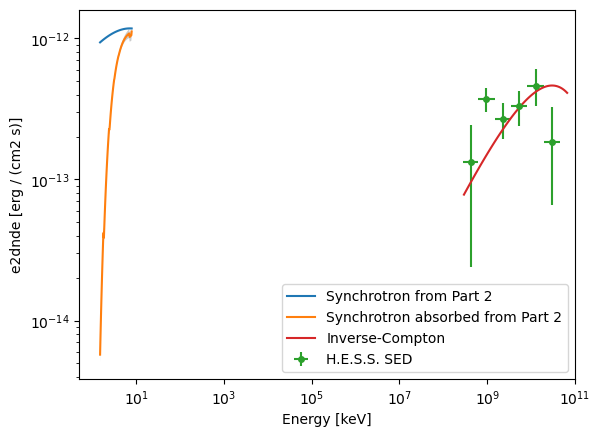

In [44]:
opts = {
    "sed_type": "e2dnde",
    "energy_bounds": [1.5 * u.keV, 8 * u.keV]
}

synchrotron.plot(label="Synchrotron from Part 2", **opts)

synchrotron_absorbed.plot(label="Synchrotron absorbed from Part 2", **opts)
synchrotron_absorbed.plot_error(**opts)

hess_sed.plot(label="H.E.S.S. SED", sed_type="e2dnde")

opts = {
    "sed_type": "e2dnde",
    "energy_bounds": hess_source.energy_range
}

inverse_compton.plot(label="Inverse-Compton", **opts)

plt.xlim(0.5, 100e9)
plt.legend()

In [45]:
model_naima_IC = SkyModel(spectral_model=inverse_compton, name="inverse-compton", datasets_names=[hess_dataset.name])

Assign the models to the datasets:

In [46]:
mwl_datasets.models = [model_naima_syn, model_naima_IC]

Under a single-zone assumption, we link the electron spectral parameters between the XMM and H.E.S.S. dataset:

In [47]:
inverse_compton.amplitude = synchrotron.amplitude
inverse_compton.alpha = synchrotron.alpha
inverse_compton.e_0 = synchrotron.e_0
inverse_compton.e_cutoff = synchrotron.e_cutoff
inverse_compton.beta = synchrotron.beta

In [48]:
print(mwl_datasets.models)

DatasetModels

Component 0: SkyModel

  Name                      : synchrotron_absorbed
  Datasets names            : ['group_nNVtGBNH', 'group_IIGrQpnr', 'group_pYj7GbkV']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    nH                    (frozen):      6.203                   
    amplitude@9VanppxS            :   3.33e+31   +/- 5.1e+31 1 / eV      
    e_0@lIm94GR0          (frozen):      1.000       TeV         
    alpha@DlY-KYHa                :      1.734   +/-    0.30             
    e_cutoff@vfxRIu33     (frozen):    180.000       TeV         
    beta@VxnkpcMO         (frozen):      1.000                   
    B                     (frozen):      3.000       uG          

Component 1: SkyModel

  Name                      : inverse-compton
  Datasets names            : ['TbutzLZZ']
  Spectral model type       : NaimaSpectralModel
  Spatial  model type       : 
  Temporal model type      

### Fit

In [49]:
mwl_datasets.models.parameters.free_parameters.unique_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str4,float64,float64,float64,bool,bool,str18
spectral,amplitude,3.3274e+31,eV-1,5.097e+31,4.000e+29,4.000e+35,False,True,amplitude@9VanppxS
spectral,alpha,1.7342e+00,,2.999e-01,1.000e+00,4.000e+00,False,False,alpha@DlY-KYHa


In [ ]:
%%time
fit = Fit()
fit_result = fit.run(mwl_datasets)

/home/lucagiunti/miniconda3/envs/gammapyXray/lib/python3.9/site-packages/sherpa/astro/xspec/__init__.py:1179: FutureWarning: calc() requires pars,lo,hi arguments, sent 2 arguments
  warnings.warn(emsg, FutureWarning)


Inspect the fit output:

In [ ]:
print(fit_result)

In [ ]:
fit_result.parameters.to_table()

In [ ]:
ax_spectrum, ax_residuals = pn_dataset.plot_fit()
ax_spectrum.set_xlim(1.5, 8)
ax_residuals.set_xlim(1.5, 8)

In [ ]:
pn_dataset.plot_residuals_spectral(color="r", label="PN")
mos1_dataset.plot_residuals_spectral(color="g", label="MOS1")
mos2_dataset.plot_residuals_spectral(color="b", label="MOS2")
plt.legend()
plt.xlim(1.5, 8)

In [ ]:
ax_spectrum, ax_residuals = hess_dataset.plot_fit()

In [ ]:
opts = {
    "sed_type": "e2dnde",
    "energy_bounds": [1.5 * u.keV, 8 * u.keV]
}

synchrotron.plot(label="Synchrotron", **opts)
synchrotron.plot_error(**opts)

synchrotron_absorbed.plot(label="Synchrotron absorbed", **opts)
synchrotron_absorbed.plot_error(**opts)

hess_sed.plot(label="H.E.S.S. SED", sed_type="e2dnde")

opts = {
    "sed_type": "e2dnde",
    "energy_bounds": hess_source.energy_range
}

inverse_compton.plot(label="Inverse-Compton", **opts)
inverse_compton.plot_error(**opts)

plt.xlim(0.5, 100e9)
plt.legend()